In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/DataIntelligenceApplications/')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.basic_generator import BasicDataGenerator
from environments.pricing_environment import PricingEnvironment
from environments.joint_environment import JointEnvironment
from learners.joint.thompson_sampling_Joint import ThompsonSampling
from learners.pricing.ucb import UCB
from learners.joint.GPTS_Learner_v2_Joint import GPTS_Learner

In [36]:
##SIMULATION PARAMETERS
data_gen = BasicDataGenerator(filename='src/basic003.json')
prices = data_gen.get_prices()
bids = data_gen.get_bids()
margins = data_gen.get_margins()
conv_rates = data_gen.get_conversion_rates(mode='aggregate')
n_clicks = data_gen.get_daily_clicks(mode='aggregate')
costs_per_click = data_gen.get_costs_per_click(mode='aggregate')
aggr_tau = data_gen.get_future_purchases(mode='aggregate')

n_arms = len(prices)
env_params = {
        'mode': 'aggregate',
        'src': 'src/basic003.json'
}

T = 200
n_experiments = 5

print(15*'-','DATA', '-'*15)
print(f'prices={prices}')
print(f'bids={bids}')
print(f'margins={margins}')
print(f'conv_rates{conv_rates}')
print(f'cost_per_click={costs_per_click}')
print(f'n_clicks={n_clicks}')
print(f'aggr_tau={aggr_tau}')
print('\n', 15 * '-', 'SIMULATION PARAMS', '-' * 15)
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')

--------------- DATA ---------------
prices=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
bids=[0.3, 0.35, 0.4, 0.5, 0.6, 0.75, 0.9, 1.0, 1.25, 1.5]
margins=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
conv_rates[0.204 0.211 0.205 0.189 0.176 0.152 0.128 0.113 0.097 0.09 ]
cost_per_click=[0.294 0.342 0.389 0.483 0.576 0.713 0.847 0.935 1.151 1.361]
n_clicks=[115.248 124.161 131.72  143.8   152.973 163.133 170.442 174.226 181.125
 185.61 ]
aggr_tau=[2.85  2.485 2.12  1.755 1.39  1.025 0.84  0.69  0.65  0.65 ]

 --------------- SIMULATION PARAMS ---------------
Time horizon: 200 days
Num. experiments: 5


In [5]:
#Manually compute optimum for check
expected = []
for bid_id in range(0, len(bids)):
  for price_id in range(0, len(prices)):
    exp = n_clicks[bid_id] * (conv_rates[price_id] * margins[price_id] * (1 + aggr_tau[price_id]) - costs_per_click[bid_id])
    expected = np.append(expected, exp)
opt_val = np.max(expected)
print(f'Optimal val: {opt_val}')

Optimal val: 405.385505


In [ ]:
rewards_per_experiment = []
gpts_rewards_per_experiment = []

for e in range(n_experiments):
    print(f'running experiment {e+1}/{n_experiments}...')
    test_instances = []
    ts_learner = ThompsonSampling(arm_values=margins)
    gpts_learner = GPTS_Learner(arms = bids)
    env = JointEnvironment(**env_params)

    for t in range(T):

        ts_learner.next_day()

        bidding_pulled_arm = gpts_learner.pull_arm()
        bidding_reward = env.bidding_round(bidding_pulled_arm)

        month_purchases = env.get_next_purchases_at_day(t, keep=False)
        if month_purchases is not None:
            pulled_arms = env.get_selected_arms_at_day(t - 30, keep=False)
            for arm, n_purchases in zip(pulled_arms, month_purchases):
                ts_learner.update_single_future_purchase(arm, n_purchases)
        pulled_arm = ts_learner.pull_arm()
        daily_reward = env.day_round(pulled_arm, bidding_reward['n_clicks'], bidding_reward['cpc'])
        #daily_reward = env.day_round(pulled_arm, n_clicks[3], costs_per_click[3])
        for outcome, cost in daily_reward:
            ts_learner.update(pulled_arm, outcome, cost)

        bidding_reward['tau'] = ts_learner.next_purchases_estimation[pulled_arm]
        #bidding_reward['conv_rates'] = np.sum(daily_reward[:,0])/np.size(daily_reward[:,0])
        bidding_reward['conv_rates'] = ts_learner.get_est_conv_rates()
        bidding_reward['margin'] = bidding_reward['margin'][pulled_arm]

        gpts_learner.update(bidding_pulled_arm, bidding_reward)

    rewards_per_experiment.append(ts_learner.daily_collected_rewards)
    gpts_rewards_per_experiment.append(gpts_learner.daily_collected_rewards)

In [8]:
#Get optimum from env
opt = env.get_opt()
print(f'combined opt arm n°{env.get_opt_arm()}')
print(f'combined opt = {opt}')

combined opt arm n°52
combined opt = 405.385505


In [9]:
rewards_per_experiment[0]

array([ 38.8699306 , -14.49750119,  65.38824664, 121.52627616,
       111.09458294, 115.28323114,  29.47869327,  -7.55752802,
        71.67185189,  20.36073342,  76.05019358, 168.79240804,
       102.13259977,  86.46017722,  35.62278223, 111.87543502,
       143.84037567, 167.0384577 ,  36.47346961,  84.00395584,
       101.24464633,  56.41700087, 104.49041615,  88.77545026,
        80.78903759,  85.47739431, 122.60511581, 102.088596  ,
        82.10781586,  66.9196316 , 130.80748915, 220.16023344,
       240.41769698, 295.6776865 , 257.71016973, 372.36689382,
       233.49655683, 434.53004656, 455.92935656, 409.24786741,
       355.72958308, 405.12022091, 321.83986079, 383.77803087,
       513.06821199, 290.80544931, 405.82981459, 274.02659114,
       510.11232943, 289.27877845, 462.89251139, 370.54399903,
       436.22345113, 312.71596922, 440.51468072, 419.20693978,
       449.95360093, 398.76691986, 436.45583475, 443.59965554,
       432.18073148, 438.75895374, 300.18428202, 368.54

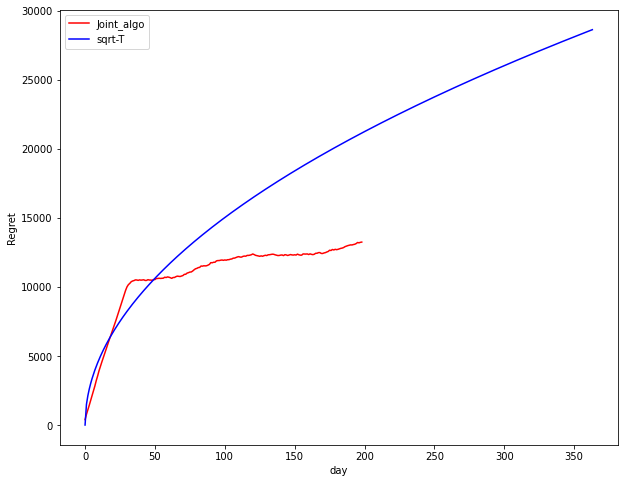

In [33]:
#Plot the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
plt.plot(np.cumsum(np.mean(opt - rewards_per_experiment, axis=0)), 'r')
plt.plot(1500*np.sqrt(np.linspace(0,364,364)), 'b')
plt.legend(['Joint_algo', 'sqrt-T'])
plt.show()

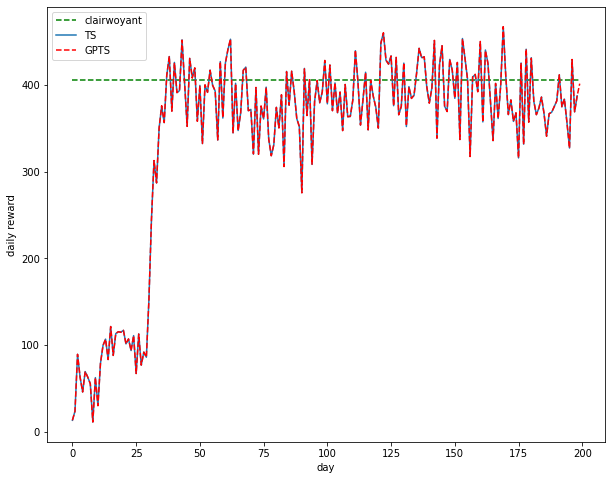

In [12]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([opt]*T, '--g', label='clairwoyant')
plt.plot(np.mean(rewards_per_experiment, axis=0), label='TS')
plt.plot(np.mean(gpts_rewards_per_experiment, axis=0),'--r' ,label='GPTS')
plt.legend(loc='best')
plt.show()

In [37]:
#Check optimum indexes
for bid_idx in range(0, len(bids)):
    for price_idx in range(0, len(prices)):
                exp = n_clicks[bid_idx] * (conv_rates[price_idx] * margins[price_idx] * \
                       (1 + aggr_tau[price_idx]) - costs_per_click[bid_idx])
                if(exp == env.get_opt()):
                  print(f'bid idx = {bid_idx}')
                  print(f'price_idx = {price_idx}')

5
2


In [19]:
len(gpts_learner.outcome_per_arm[5])

169

In [ ]:
gpts_learner.outcome_per_arm[5]

In [16]:
gpts_learner.outcome_per_arm[7]

[46.46691207372781, 24.334958681537586]

In [38]:
len(ts_learner.outcome_per_arm[2])

18875